
### Task A 
Choose appropriate X and A  use dynamic programming (programmed in 
python) to determine the total expected profit and the optimal order policy, 
starting with 0 inventory at time 0

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns


In [2]:
def get_policy():
    T = 1000
    x_max = 400
    # holding cost
    h = 0.01
    # purchase cost
    c = 10
    # selling price
    p = 20
    # order cost
    K = 10

    V = np.array([[float(0) for i in range(T)] for j in range(x_max + 1)])
    alpha = np.array([[float(0)for i in range(T)] for j in range(x_max + 1)])

    # initialize the last column: hx
    V[:, -1] = [x * h for x in range(0, x_max + 1)] 

    for t in range(T - 2, -1, -1):
        c = 10 if t <= 500 else 15
        # P(D=1) distribution
        dIsOne = t / 1000
        dIsZero = 1 - dIsOne
        if t > 900:
            # At t > 900 no order can be placed, so a = 0
            for x in range(0, x_max + 1):
                if x > 0:
                    # reward only exists when x > 0 since no more action can be taken
                    E = dIsOne * V[x - 1][t + 1] + dIsZero * V[x - 0][t + 1]  
                    V[x][t] = (-h * x) + (dIsOne * p) + E
                else:
                    # in case x = 0, x stays 0 for the rest of the time because no buying is possible
                    # Vx(t) = Vx(t+1) because no more profit can be made when the inventory is empty regardless the value of P(d=1)
                    V[x][t] = V[x][t + 1]
                # optimal policy remains unchanged after t = 900
                alpha[x][t]= alpha[x][t+1]
        # when  t <= 900
        else: 
            for x in range(0, x_max + 1):
                # Q stores values for all possible actions
                Q = {}
                for a in range(0 , x_max - x + 1):
                    # in case dIsOne, it's possible that x - d + a < 0 which means \
                    # there is a determined lost sale at t + 1, however, there is no x = -1 at t + 1 \
                    # since there is no backorder, the V[-1][t+1] will just be 0
                    if x - 1 + a < 0:
                        E = dIsOne * 0 + dIsZero * V[x - 0 + a][t + 1] 
                    else:
                        E = dIsOne * V[x - 1 + a][t + 1] + dIsZero * V[x - 0 + a][t + 1] 
                    Q[a] = (-h * x) - K * (a > 0) - (c * a)  + (dIsOne * p) + E
                # find the max values and the corresponding policy
                V[x][t] = max(Q.values())
                alpha[x][t]= max(Q, key = Q.get)
    return (alpha, V)


In [3]:
optimal_policy, expected_profit = get_policy()

In [4]:
print('The total expected profit is', expected_profit[0,0])
print('The optimal policy is stored in the optimal_policy')

The total expected profit is 3787.1525574965212
The optimal policy is stored in the optimal_policy


### Task B
Visualize the optimal policy and explain its structure in words, why you think this is logical

<AxesSubplot: xlabel='time', ylabel='optimal_action'>

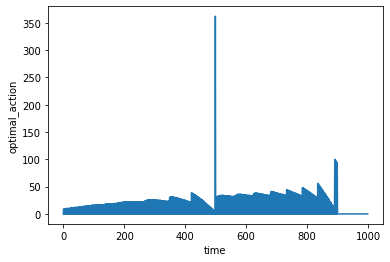

In [31]:
optimal_action_dict = {}
current_state = 0
for t in range(0, len(optimal_policy[0])):
    optimal_action_dict[t] = (optimal_policy[current_state][t])
    current_state = int(optimal_policy[current_state][t])

optimal_policy_df = pd.DataFrame(optimal_action_dict.items(), columns=['time', 'optimal_action'])

sns.lineplot(data=optimal_policy_df, x='time', y='optimal_action')

### Task C

Simulate 10 times the demand over time starting from inventory 0, record the state and apply the optimal policy. For each trace plot the inventory and lost sales in a graph.

In [6]:
# Number of simulations 
MAX_SIM = 10

# To store the inventory level fo each simulation
inventory_lvl_list = []
# To store the lost sale of each simulation
lost_sale_list = []

for sim in range(1, MAX_SIM + 1):
    # stores inventory lvl at each time period
    inventory_lvl_dict = {}
    inventory = 0

    #stores cumulative lost sales at each time period
    lost_sale_dict = {}
    lost_sale = 0

    for t in range(1, len(optimal_policy[0]) + 1):
        dIsOne = t / 1000
        dIsZero = 1 - dIsOne
        # d is assigned to 1 or 0 based on the weights of dIsOne and dIsZero
        d = random.choices([1, 0], weights=(dIsOne, dIsZero), k = 1)[0]
        inventory += optimal_policy[int(inventory)][t - 1] - d
        inventory_lvl_dict[t] = inventory
        if inventory == 0 and d > 0:
            lost_sale += 1
            
        lost_sale_dict[t] = lost_sale

    # Saving the inventory level results  of current simulation 
    tmp_df = pd.DataFrame(inventory_lvl_dict.items(), columns=['time', 'inventory_lvl'])
    tmp_df['simulation'] = sim
    inventory_lvl_list.append(tmp_df)

    # Saving the lost sales results of current simulation 
    tmp_df = pd.DataFrame(lost_sale_dict.items(), columns=['time', 'lost_sale'])
    tmp_df['simulation'] = sim
    lost_sale_list.append(tmp_df)



<AxesSubplot: xlabel='time', ylabel='lost_sale'>

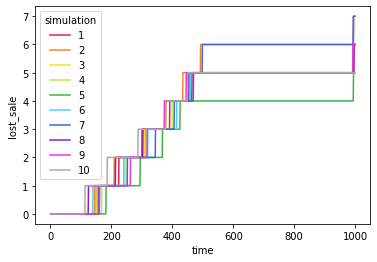

In [7]:
lost_sale_df = pd.concat(lost_sale_list)

sns.lineplot(data=lost_sale_df, x='time', y='lost_sale', hue='simulation', \
    palette=['#e6194B', '#f58231', '#ffe119', '#bfef45', '#3cb44b', '#42d4f4', '#4363d8', '#911eb4', '#f032e6', '#a9a9a9'])

<AxesSubplot: xlabel='time', ylabel='inventory_lvl'>

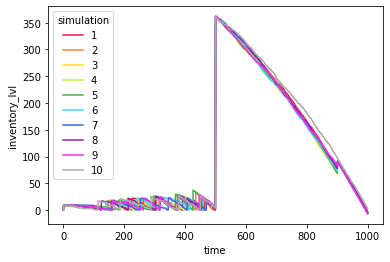

In [8]:
inventory_lvl_df = pd.concat(inventory_lvl_list)

sns.lineplot(data=inventory_lvl_df, x='time', y='inventory_lvl', hue='simulation', \
palette=['#e6194B', '#f58231', '#ffe119', '#bfef45', '#3cb44b', '#42d4f4', '#4363d8', '#911eb4', '#f032e6', '#a9a9a9'])

In [9]:
# Number of simulations 
MAX_SIM = 10

# To store the inventory level fo each simulation
inventory_lvl_list = []
# To store the lost sale of each simulation
lost_sale_list = []

# To store total profit of each simulation
profit_list = []

for sim in range(1, MAX_SIM + 1):
    # stores inventory lvl at each time period
    inventory_lvl_dict = {}
    inventory = 0

    #stores cumulative lost sales at each time period
    lost_sale_dict = {}
    lost_sale = 0

    # stores profit of current simulation
    profit = 0
    is_lost_sale = False

    # holding cost
    h = 0.01

    for t in range(1, len(optimal_policy[0]) + 1):
        dIsOne = t / 1000
        dIsZero = 1 - dIsOne
        # d is assigned to 1 or 0 based on the weights of dIsOne and dIsZero
        d = random.choices([1, 0], weights=(dIsOne, dIsZero), k = 1)[0]
        inventory += optimal_policy[int(inventory)][t - 1] - d


        # cost of purchasing at different times post t=900 no item can be purchased
        c = 10 if t <= 500 else (15 if t <= 900 else None)
        # selling price is 20 and constant
        sp = 20

        # profit calculation
        if c is not None:
            profit += d * sp - optimal_policy[int(inventory)][t - 1] * c - inventory * h
        else :
            profit +=  d * sp - h * inventory

        profit_list.append(profit)


        inventory_lvl_dict[t] = inventory
        if inventory == 0 and d > 0:
            lost_sale += 1
            is_lost_sale = True
            
        lost_sale_dict[t] = lost_sale

In [28]:
profit = 0
K = 10
for t in range(0, len(optimal_policy[0])):
    dIsOne = t / 1000
    dIsZero = 1 - dIsOne
    # d is assigned to 1 or 0 based on the weights of dIsOne and dIsZero
    
    # cost of purchasing at different times post t=900 no item can be purchased
    c = 10 if t <= 500 else (15 if t <= 900 else None)
    # selling price is 20 and constant
    sp = 20
    d = random.choices([1, 0], weights=(dIsOne, dIsZero), k = 1)[0]
    if c is not None:
        profit += d * sp - optimal_policy[int(inventory)][t] * c - inventory * h 
    else :
        profit +=  d * sp - h * inventory

    E = dIsOne * V[x - 1 + a][t + 1] + dIsZero * V[x - 0 + a][t + 1] 
    Q[a] = (-h * x) - K * (a > 0) - (c * a)  + (dIsOne * p) + E

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

In [27]:
profit

10030.000000000116